Bonhoure Timothé et Martinez Christophe

# GNN : Projet

In [1]:
#import

import torch
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.nn import VGAE
import networkx as nx
from sklearn.preprocessing import LabelEncoder

from GCN import GCN, SimpleGCN
from encoder import Encoder
from decoder import Decoder

from sklearn.metrics import confusion_matrix
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
import time

from itertools import combinations
import copy

In [ ]:
# Load the network
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")

[]

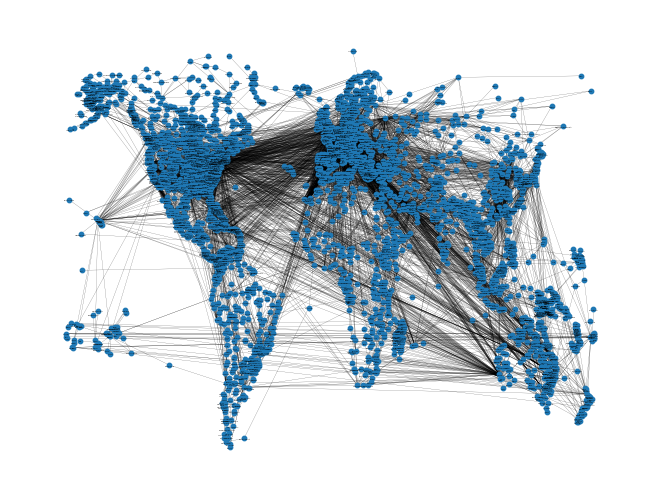

In [ ]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}
labels = {node: (data['city_name']) for node, data in G.nodes(data=True)}
nx.draw_networkx_edges
nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.1)
plt.plot()

In [ ]:
G.graph = {} 
data = from_networkx(G, group_node_attrs=["lon","lat"])

print(data)
print(data.num_features)
print(len(set(data.country)))

Data(edge_index=[2, 27094], population=[3363], country=[3363], city_name=[3363], x=[3363, 2])
2
212


In [ ]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.country)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.country))

In [ ]:
num_nodes = data.num_nodes
train_ratio = 0.80 # 80% of nodes for training
# Randomly creating a mask
mask = torch.rand(num_nodes) < train_ratio
data.train_mask = mask
data.test_mask = data.train_mask
# remove the attributes for the nodes that are not in the training set
temp = torch.zeros((num_nodes, 2), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp

In [ ]:
print(data.x)

tensor([[-145.5097,  -17.3539],
        [-140.9500,  -18.0667],
        [-149.6000,  -17.5500],
        ...,
        [-113.2039,   54.7431],
        [ 146.6000,   -6.1333],
        [ 147.2500,   -6.0000]])


In [ ]:
model = GCN(dim_in=data.num_features, dim_h=100, dim_out=data.num_classes)
model.fit(data, 100)

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


In [ ]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5473


In [ ]:
G.graph = {} 
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]


data = from_networkx(G, group_node_attrs=["lon","lat","country_code"])

print(data)
print(data.num_features)

Data(edge_index=[2, 27094], population=[3363], country=[3363], city_name=[3363], x=[3363, 3])
3


In [ ]:
dt = data.__copy__()
train_test_split_edges(dt)
print(dt)
dt.num_classes = len(set(data.country))

Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 3], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


/home/stouf/.local/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [5]:
def fit(model, data, epochs, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(epochs+1):
        if epoch % 100 == 0 and verbose :
            z = model.encode(data.x, data.train_pos_edge_index)
            print(epoch, " : ", model.test(z, data.test_pos_edge_index, data.test_neg_edge_index))
        optimizer.zero_grad()
        z = model.encode(data.x, data.train_pos_edge_index)
        loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()

In [ ]:
encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=0.0)
decoder = Decoder(15)

vgae = VGAE(encoder, decoder)

fit(vgae, dt, 2000)

z = vgae.encode(dt.x, dt.train_pos_edge_index)
AUC, PA = vgae.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index)

0  :  (0.4891936251033646, 0.49469490364035257)
100  :  (0.9133259078085828, 0.9152756462397534)
200  :  (0.9025301693761468, 0.9023580508486826)
300  :  (0.9118155298922828, 0.9115449016087582)
400  :  (0.9297161536799985, 0.930470366401631)
500  :  (0.9255447506049147, 0.9272618220060772)
600  :  (0.9185541390573146, 0.9176211219564547)
700  :  (0.9264761230469816, 0.9250045178310979)
800  :  (0.924083464061842, 0.9225291202419844)
900  :  (0.9365343999615996, 0.9373704025759877)
1000  :  (0.9177201311721495, 0.9172957203180914)
1100  :  (0.9129020856197186, 0.9123242034964851)
1200  :  (0.9132179067874824, 0.914217874883796)
1300  :  (0.9165359381579608, 0.9146055844331944)
1400  :  (0.9268666721939917, 0.9257015239527149)
1500  :  (0.9310383479989266, 0.9289983666137541)
1600  :  (0.9296242437201223, 0.9271663527934342)
1700  :  (0.9265595783814683, 0.9267379551343284)
1800  :  (0.9339971941552903, 0.9360624734664482)
1900  :  (0.9286418707958694, 0.9279135740669566)
2000  :  (0.91

In [ ]:
def test_dropout(file_path, dropouts, epochs):
    dt = data.__copy__()
    train_test_split_edges(dt)
    print(dt)
    dt.num_classes = len(set(data.country))
    
    with open(file_path, "w") as f:
        f.write("Dropout;AUC;AP;epochs;elapsed_time\n")

    for dropout in dropouts:
        print("Dropout : ", dropout)
        
        encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=dropout)
        vgae = VGAE(encoder)
        
        start_time = time.time()
        fit(vgae, dt, epochs, verbose=False)
        elapsed_time = time.time() - start_time

        z = vgae.encode(dt.x, dt.train_pos_edge_index)
        AUC, AP = vgae.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index)
        
        with open(file_path, "a") as f:
            f.write(f"{dropout};{AUC};{AP};{epochs};{elapsed_time}\n")
        print(f"{dropout};{AUC};{AP};{epochs};{elapsed_time}")

In [ ]:
for i in range(10):
    test_dropout("test_dropout/test" + str(i+1) + ".csv", [.0,.1,.2,.3,.4,.5,.6,.7], 2000)

In [ ]:
mean_data = pd.read_csv("test_dropout/test1.csv", sep=";")
mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]].applymap(lambda x: 0)

for i in range(10):
    df = pd.read_csv("test_dropout/test"+ str(i+1) + ".csv", sep=";")
    mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] + df[["Dropout", "AUC", "AP", "elapsed_time"]] / 10.0

mean_data[["Dropout"]] = mean_data[["Dropout"]].round(1)
mean_data.to_csv("test_dropout/mean.csv", sep=";", index=False)
mean_data

/tmp/ipykernel_87409/1360025467.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]].applymap(lambda x: 0)


,Dropout,AUC,AP,epochs,elapsed_time
0,0.0,0.944674,0.929142,2000,42.126361
1,0.1,0.918398,0.906737,2000,41.715540
2,0.2,0.931087,0.932548,2000,41.847366
3,0.3,0.914220,0.918895,2000,41.685487
4,0.4,0.910201,0.913932,2000,41.578512
5,0.5,0.900713,0.904036,2000,41.639460
6,0.6,0.881984,0.882945,2000,41.636460
7,0.7,0.880589,0.882256,2000,41.681939


## Reconstruction de graphe

In [3]:
# Reconstruction du graphe
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")
G.graph = {}
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]

data = from_networkx(G, group_node_attrs=["lat","lon","country_code"])

true_edges = copy.deepcopy(G.edges)

In [7]:
dt = data.__copy__()
dt.num_classes = len(set(data.country))
train_test_split_edges(dt)

encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=0.0)
decoder = Decoder(15)

vgae = VGAE(encoder, decoder)
vgaeWithoutDecoder = VGAE(Encoder(in_channels=dt.num_features, out_channels=15, dropout=0.0))

fit(vgae, dt, 1000, verbose=True)
fit(vgaeWithoutDecoder, dt, 1000, verbose=True)

/home/stouf/anaconda3/envs/BIML/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


0  :  (0.4953338649747234, 0.4974200375896888)
100  :  (0.9535410152968719, 0.9521319921620734)
200  :  (0.9597330738399708, 0.9591921875085577)
300  :  (0.9601808962557464, 0.959621514855439)
400  :  (0.96437384498908, 0.9636937012396616)
500  :  (0.9608002657479673, 0.9603805405046443)
600  :  (0.9630680144612276, 0.9626651559339918)
700  :  (0.9667836859548491, 0.9662473097299813)
800  :  (0.9682065175888935, 0.9676664218891209)
900  :  (0.9651429431696444, 0.9644559383962714)
1000  :  (0.9528526451522814, 0.9503831976879016)
0  :  (0.48966026587887745, 0.49493564043047056)
100  :  (0.8203891200425895, 0.740072692873877)
200  :  (0.822574231610917, 0.7452476395478793)
300  :  (0.8534022503485488, 0.7812649039923683)
400  :  (0.8691065806440352, 0.7988106699416669)
500  :  (0.8807316905541652, 0.8157366869514672)
600  :  (0.8733881665790295, 0.8062369589740833)
700  :  (0.8834949894071725, 0.8205111001399896)
800  :  (0.8548823552513587, 0.7881542433665311)
900  :  (0.920977071055944

In [9]:
def predict_graph(data, model, G, true_edges, sigmoid, file_path):
  print("Preparing combinations of edges...")
  num_nodes = data.x.shape[0]

  all_node_indices = torch.arange(num_nodes)

  edge_index_combinations = None

  # Créer toutes les combinaisons possibles de deux nœuds
  edge_index_combinations = torch.tensor(list(combinations(all_node_indices, 2)), dtype=torch.long).t()

  #----
  print("Predicting edges...")
  with torch.no_grad():
    z = model.decoder(model.encode(data.x, data.train_pos_edge_index), edge_index_combinations, sigmoid=sigmoid)
  edges_transpose = torch.transpose(edge_index_combinations, 0, 1)

  print(len(z), " possible edges")
  print("Prediction min and max : ", torch.min(z).item(), torch.max(z).item())
  print("Prediction mean and std : ", torch.mean(z).item(), torch.std(z).item())

  #---
  print("Selecting edges...")
  threshold = torch.quantile(z, 1 - len(true_edges) / edges_transpose.shape[0], interpolation='nearest')
  print("Threshold : ", threshold)
  G.clear_edges()
  for i in range(edges_transpose.shape[0]):
      source, target = edges_transpose[i]
      edge = (str(source.item()), str(target.item()))
      if z[i] > threshold :
          G.add_edge(*edge, color = 'black' if edge in true_edges else 'r')
      elif edge in true_edges :
          G.add_edge(*edge, color = 'g')

  count = {'black':0, 'r':0, 'g':0}
  color = nx.get_edge_attributes(G,'color')
  for edge in G.edges:
    count[color[edge]] += 1
  print(count['black'], " correctly predicted")
  print(count['r'], " wrongly predicted")
  print(count['g'], " missed")

  #---
  print("Printing...")
  node_positions = {}
  labels = {}
  for node, data in G.nodes(data=True):
      try:
          node_positions[node] = (data['lon'], data['lat'])
          labels[node] = (data['city_name'])
      except:
          node_positions[node] = (0,0)
          labels[node] = ('unknown')

  # Tracez le graphe
  nx.draw_networkx_edges
  nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.05, edge_color=nx.get_edge_attributes(G,'color').values())

  plt.savefig(file_path, dpi=1000)

  return z

Preparing combinations of edges...
Predicting edges...
5653203  possible edges
Prediction min and max :  0.5 0.9999998807907104
Prediction mean and std :  0.526860237121582 0.08951286971569061
Selecting edges...
Threshold :  tensor(0.9925)
3643  correctly predicted
9904  wrongly predicted
9893  missed
Printing...


tensor([0.9544, 0.8891, 0.9542,  ..., 0.5000, 0.5000, 0.8904])

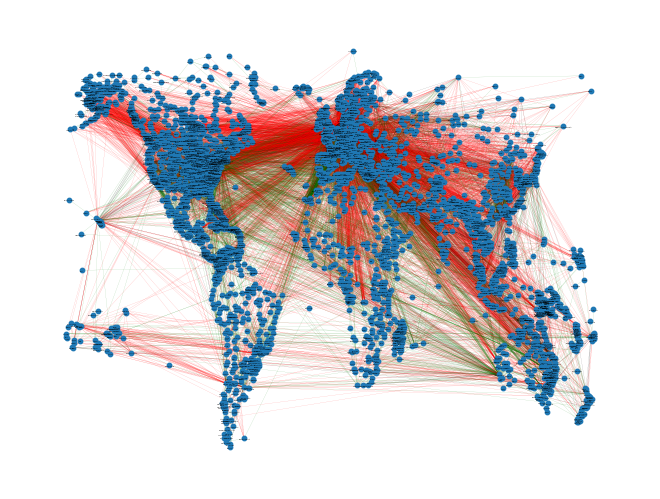

In [10]:
predict_graph(dt, vgae, G, true_edges, True, "withDecoder.png")

Preparing combinations of edges...
Predicting edges...
5653203  possible edges
Prediction min and max :  -388.001953125 3323.661865234375
Prediction mean and std :  2.327091932296753 50.127376556396484
Selecting edges...
Threshold :  tensor(533.4991)
399  correctly predicted
13148  wrongly predicted
13137  missed
Printing...


tensor([557.1635, 859.0743, 557.1594,  ...,  -9.3447,  -8.1359,  46.7426])

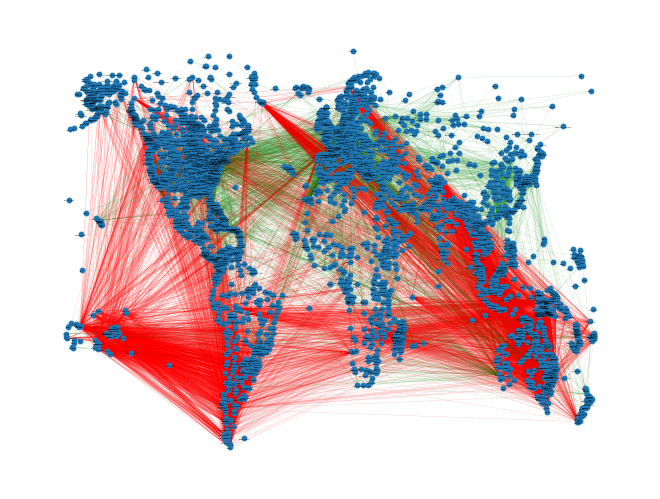

In [11]:
predict_graph(dt, vgaeWithoutDecoder, G, true_edges, False, "withoutDecoder.png")

In [ ]:
# Préparation des données
num_nodes = dt.x.shape[0]

all_node_indices = torch.arange(num_nodes)

edge_index_combinations = None

# Créer toutes les combinaisons possibles de deux nœuds
edge_index_combinations = torch.tensor(list(combinations(all_node_indices, 2)), dtype=torch.long).t()
print(edge_index_combinations.shape)

In [ ]:
with torch.no_grad():
    z = vgae.decoder(vgae.encode(dt.x, dt.train_pos_edge_index), edge_index_combinations)
    zWithoutDecoder = vgaeWithoutDecoder.decoder(vgaeWithoutDecoder.encode(dt.x, dt.train_pos_edge_index), edge_index_combinations, sigmoid=False)
edges_transpose = torch.transpose(edge_index_combinations, 0, 1)
print(z.shape, zWithoutDecoder.shape, edge_index_combinations.shape)

In [ ]:
print(torch.min(z), torch.max(z))
print(torch.mean(z), torch.std(z))
len(z)

In [ ]:
threshold = torch.quantile(zWithoutDecoder, 1 - len(true_edges) / edges_transpose.shape[0], interpolation='nearest')
print("Threshold : ", threshold)
G.clear_edges()
for i in range(edges_transpose.shape[0]):
    source, target = edges_transpose[i]
    edge = (str(source.item()), str(target.item()))
    if zWithoutDecoder[i] > threshold :
        G.add_edge(*edge, color = 'black' if edge in true_edges else 'r')
    elif edge in true_edges :
        G.add_edge(*edge, color = 'g')

In [ ]:
count = {'black':0, 'r':0, 'g':0}
color = nx.get_edge_attributes(G,'color')
for edge in G.edges:
  count[color[edge]] += 1
print(count)
print(len(G.edges))

In [ ]:
# Définissez la disposition du graphe (peut utiliser une disposition différente si nécessaire)
node_positions = {}
labels = {}
for node, data in G.nodes(data=True):
    try:
        node_positions[node] = (data['lon'], data['lat'])
        labels[node] = (data['city_name'])
    except:
        node_positions[node] = (0,0)
        labels[node] = ('unknown')

# Tracez le graphe
nx.draw_networkx_edges
nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.05, edge_color=nx.get_edge_attributes(G,'color').values())

plt.savefig("output.png", dpi=1000)

- chercher sur differentes couches
- tester dropout
- tester entrainer decodeur